In [1]:
import os 
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
os.chdir('..')
from aco4ml import *
import plotly.express as px
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold
from sklearn.datasets import load_digits, load_breast_cancer
from sklearn.ensemble import RandomForestClassifier


[SwarmPy] NumExpr defaulting to 8 threads.


In [2]:
digits = load_breast_cancer()

In [3]:

params  = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

X = np.random.uniform(size=50000).reshape((1000,50))
y = (X[:,2]>0.5).astype(int) + (X[:,12]>0.5).astype(int) + (X[:,22]>0.5).astype(int) + (X[:,32]>0.5).astype(int)


# X = digits['data']
# y = digits['target']

cut = int(len(y)*.8)
X_train,X_test  = X[:cut,:],X[cut:,:]
y_train,y_test  = y[:cut],y[cut:]
n_feature_obj = 5


G, id2hp, hp_map = Antcoder(params,X_train, y_train)

In [4]:
aco_pipeline = ACO_Pipeline(
    [
        ("Planner", Planner({"alpha": 1.0, "beta": 5.0, 'gamma' : 1.0, 'n_feature_obj' : n_feature_obj, 'n_hp' : len(params)})),
        ("Sol", SolutionConstructor(hp_map=hp_map)),
        ("DA", DaemonActions()),
        ("Updater", BestSoFarPheromonesUpdater(X=X_train, y=y_train, estimator = RandomForestClassifier, bounds=[.1, 1], Q=.1)),

    ], 
    iter_max=20,
    id2hp=id2hp, 

)

In [5]:
solutions = aco_pipeline.run(G)['solutions']

SwarmPy | Score : [0.9875]: 100%|██████████| 20/20 [42:34<00:00, 127.73s/it] 


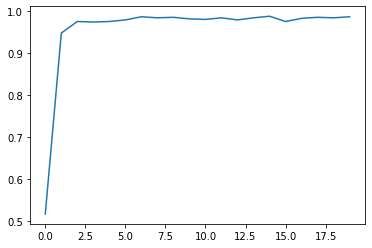

In [6]:
plt.plot([sol[1] for sol in solutions])

In [7]:
solutions

[([1, 12, 14, 22, 44, 51, 54, 57, 61], array([0.5175])),
 ([2, 10, 12, 22, 32, 50, 52, 55, 60], array([0.9475])),
 ([2, 12, 22, 32, 38, 50, 54, 58, 60], array([0.975])),
 ([2, 12, 14, 22, 32, 50, 54, 58, 60], array([0.97375])),
 ([2, 10, 12, 22, 32, 50, 53, 58, 61], array([0.975])),
 ([2, 12, 22, 27, 32, 50, 54, 57, 60], array([0.97875])),
 ([2, 12, 22, 32, 40, 50, 54, 59, 61], array([0.98625])),
 ([2, 12, 22, 32, 42, 50, 54, 59, 61], array([0.98375])),
 ([2, 9, 12, 22, 32, 50, 54, 58, 61], array([0.985])),
 ([2, 12, 22, 28, 32, 50, 52, 59, 61], array([0.98125])),
 ([2, 12, 22, 24, 32, 50, 54, 59, 61], array([0.98])),
 ([2, 5, 12, 22, 32, 50, 52, 58, 61], array([0.98375])),
 ([2, 12, 18, 22, 32, 50, 54, 58, 61], array([0.97875])),
 ([2, 12, 22, 32, 33, 50, 54, 58, 61], array([0.98375])),
 ([2, 12, 22, 32, 42, 50, 52, 58, 61], array([0.9875])),
 ([2, 12, 21, 22, 32, 50, 52, 58, 61], array([0.975])),
 ([2, 12, 22, 25, 32, 50, 54, 58, 61], array([0.9825])),
 ([2, 12, 22, 23, 32, 50, 54, 5

In [8]:
best_sol = max(solutions, key=lambda x: x[1])[0]

In [9]:
best_params = dict([id2hp[_id] for _id in best_sol[n_feature_obj:]])
best_cols = best_sol[:n_feature_obj]

In [10]:


params = []
for solution,_ in solutions:
            intermediate_list = dict([id2hp[_id] for _id in solution[n_feature_obj:]])
            params.append(intermediate_list)

In [11]:
params

[{'n_estimators': 500,
  'max_features': 'log2',
  'max_depth': 6,
  'criterion': 'entropy'},
 {'n_estimators': 200,
  'max_features': 'auto',
  'max_depth': 4,
  'criterion': 'gini'},
 {'n_estimators': 200,
  'max_features': 'log2',
  'max_depth': 7,
  'criterion': 'gini'},
 {'n_estimators': 200,
  'max_features': 'log2',
  'max_depth': 7,
  'criterion': 'gini'},
 {'n_estimators': 200,
  'max_features': 'sqrt',
  'max_depth': 7,
  'criterion': 'entropy'},
 {'n_estimators': 200,
  'max_features': 'log2',
  'max_depth': 6,
  'criterion': 'gini'},
 {'n_estimators': 200,
  'max_features': 'log2',
  'max_depth': 8,
  'criterion': 'entropy'},
 {'n_estimators': 200,
  'max_features': 'log2',
  'max_depth': 8,
  'criterion': 'entropy'},
 {'n_estimators': 200,
  'max_features': 'log2',
  'max_depth': 7,
  'criterion': 'entropy'},
 {'n_estimators': 200,
  'max_features': 'auto',
  'max_depth': 8,
  'criterion': 'entropy'},
 {'n_estimators': 200,
  'max_features': 'log2',
  'max_depth': 8,
  'cr

In [12]:
lr_aco = RandomForestClassifier(**best_params).fit(X_train[:,best_cols], y_train)
lr = RandomForestClassifier().fit(X_train, y_train)

In [13]:
print(f' ACO : {lr_aco.score(X_test[:,best_cols],y_test)}')
print(f' Not ACO : {lr.score(X_test,y_test)}')

 ACO : 0.985
 Not ACO : 0.76


In [14]:
np.sum((np.round(np.sqrt(lr_aco.coef_  / lr_aco.coef_[0][0])*2) - np.sqrt(lr_aco.coef_  / lr_aco.coef_[0][0])*2)**2)

AttributeError: 'RandomForestClassifier' object has no attribute 'coef_'

In [15]:
best_cols

[2, 12, 22, 32, 42]

In [16]:
best_params

{'n_estimators': 200,
 'max_features': 'auto',
 'max_depth': 7,
 'criterion': 'entropy'}

In [ ]:
lr_aco.coef_ 

array([[-1.41536380e+01, -1.36742192e+01, -1.32653353e+01,
        -1.34266856e+01,  6.08885712e-01],
       [-5.58269418e+00, -5.98973935e+00, -5.73501954e+00,
        -6.27837305e+00, -1.33117241e-01],
       [ 4.63104354e-01,  2.76867271e-01,  4.98523400e-01,
         5.55961675e-02, -2.91463707e-01],
       [ 7.19148655e+00,  7.05207349e+00,  6.95440006e+00,
         7.08578338e+00, -1.77642267e-01],
       [ 1.20817412e+01,  1.23350178e+01,  1.15474314e+01,
         1.25636791e+01, -6.66249735e-03]])